# Learning Cooccurrence in Biological Systems using Data Science Methods Represented via Graphical Networks

In [2]:
import pandas as pd
import numpy as np
import scipy as scp
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import datasets
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import holoviews as hv
import hvplot.networkx as hvnx
from bokeh.models import HoverTool

%matplotlib inline

## Markdown Background on Project

A greater understanding of **biological systems** via information extraction and **cooccurrence analysis** can be useful tools for knowledge inference in the field of systems biology. Unfortunately it is not entirely feasible to always physically collect such data. Using data science methods, it is possible to leverage past abundance and cooccurrence data to learn more about positive and anti-correlation relationships in varied populations and ecosystems. 

To explore this theory, we utilized **oxygen availability data**, experimentally derived from 30 different samples of Lake Washington sediment of a total for **253 varied bacterial species**. The primary objective of this investigation involved **reproducing biological knowledge**, verified by known relationships amongst **methanotrophs and methylotrophs**. 

Utilizing statistical methods – **PCA**, **covariance analysis** and **Ledoit Wolf shrinkage** to derive a **partial correlation matrix** of the species in the dataset – and visualization methods, the data was mined, processed and represented as an **interactive, undirected graphical network**. This network allows the user to learn more about the popular species per site and the correlations between all indicated species. 

Based on known knowledge that methanotrophs and methylotrophs are positively correlated and that each of the species are generally anti-correlated with themselves, we were able to verify the validity of our model via reproducibility. 

## Markdown Background on Dataset

The data used for this project is the Oxygen Availability Dataset, which indicates species abundance. 30 samples of sediment from Lake Washington were collected and analyzed with the identification of 253 individual species. The atmospheric spaces of the samples were manipulated to determine the composition of microbial communities in low and high oxygen availability. Oxygen and methane concentrations were measured using gas chromatography over a 16 week timeframe. The data was collected, analyzed and show positive and anti-cooccurrence relations, presented via a heatmap, which highlight interesting distinctions. 

## Part I - Clean Oxygen-Availability Dataset (OAD)

- Convert excel spreadsheet to a dataframe
- Keep rows of intrest and drop all other rows
- Store rows and columns as samples and sites

In [3]:
#Initialize dataframe from excel spreadsheet
oad = pd.read_excel("oxy_avail_dataset.xls")
oad.head()

,OTUId,45A 10,45B 10,45C 10,75A 10,75B 10,75C 10,150A 10,150B 10,150C 10,...,class_confidence,order_,order_confidence,family,family_confidence,genus,genus_confidence,species,species_confidence,sequence
0,OTU_1,24014,12430,477,231,35910,9801,6183,22212,5628,...,1.0,Methylophilales,1.0,Methylophilaceae,1.0,Methylophilus,1.00,NaN,NaN,ATTGAACGCTGGCGGAATGCTTTACACATGCAAGTCGAACGATGAA...
1,OTU_2,20188,24781,13429,22430,22253,24440,684,688,622,...,1.0,Methylococcales,1.0,Methylococcaceae,1.0,Methylobacter,1.00,NaN,NaN,ATTGAACGCTGGCGGTATGCTTAACACATGCAAGTCGAACGGTAGC...
2,OTU_3,2417,5259,29605,790,591,8685,1698,318,105,...,1.0,Methylophilales,1.0,Methylophilaceae,1.0,Methylotenera,1.00,NaN,NaN,ATTGAACGCTGGCGGAATGCTTTACACATGCAAGTCGAACGATGAT...
3,OTU_5,289,363,208,259,366,331,18787,10820,5755,...,1.0,Methylococcales,1.0,Methylococcaceae,1.0,Methylosarcina,1.00,NaN,NaN,ATTGAACGCTGGCGGTATGCTTAACACATGCAAGTCGAACGGTAAC...
4,OTU_4,98,98,5834,856,361,192,72,199,72,...,1.0,Methylophilales,1.0,Methylophilaceae,1.0,Methylotenera,0.95,NaN,NaN,ATTGAACGCTGGCGGAATGCTTTACACATGCAAGTCGAACGGCAGC...


In [4]:
#Drop rows that describe the index and set the index
oad_cleaned = oad.loc[:, :'225C 16'].set_index('OTUId')
oad_cleaned.head()

,45A 10,45B 10,45C 10,75A 10,75B 10,75C 10,150A 10,150B 10,150C 10,15A 10,...,75C 16,150A 16,150B 16,150C 16,15A 16,15B 16,15C 16,225A 16,225B 16,225C 16
OTUId,,,,,,,,,,,,,,,,,,,,,
OTU_1,24014,12430,477,231,35910,9801,6183,22212,5628,239,...,5380,4219,7319,16424,187,198,407,10191,10663,3043
OTU_2,20188,24781,13429,22430,22253,24440,684,688,622,12923,...,5242,380,462,1213,5432,6266,8964,1274,660,212
OTU_3,2417,5259,29605,790,591,8685,1698,318,105,785,...,9096,1619,396,545,5873,3991,423,689,326,70
OTU_5,289,363,208,259,366,331,18787,10820,5755,176,...,90,2536,1912,74,67,83,88,2604,4620,2865
OTU_4,98,98,5834,856,361,192,72,199,72,17345,...,254,34,119,103,1671,4136,2690,47,0,9


In [5]:
#Make list of indecies and column headers
samples = list(oad_cleaned.index.values)
sites = list(oad_cleaned)

## Transpose and Normalize OAD data

#### The dataset initially consisted of the samples forming the columns and the species as the rows. It is a common and long-standing convention in statistics that data matrices have observations in rows and variables in columns. Since the species are the factors of interest, and PCA is conducted on columns, transposing the data allowed for the best manipulation in following stages. 

#### The dataset must also be normalized to accomodate for values of abundance from 0 to over 35,000. The StandardScaler object assumes the data is normally distributed within each feature and scales it such that the distribution is now centred around 0, with a standard deviation of 1.

 - Transpose data as the species are the factors of importance
 - Normalize data so that all values are within a useable range (as opposed to the 0 - 35,000 range in it's natural form), and can be processed in further steps
 - Use scikitlearn's preprocessing.StandardScalar function as this function scales according to the unit variance, so now the range is much smaller
 - Update transposed row and column labels to their actual names (not based on the PCs from PCA)

In [6]:
#Transpose cleaned data table to get the index to be the sites and the columns to be the samples
oad_t = oad_cleaned.T
oad_t.head()

OTUId,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
45A 10,24014,20188,2417,289,98,60,808,53,21,15,...,0,0,0,0,0,0,0,0,0,0
45B 10,12430,24781,5259,363,98,79,74,9,9,9,...,0,0,0,0,0,0,0,0,0,0
45C 10,477,13429,29605,208,5834,45,1140,52,17,9,...,0,0,0,0,0,0,0,0,0,0
75A 10,231,22430,790,259,856,51,611,8,25,9657,...,0,0,0,0,0,0,0,0,0,0
75B 10,35910,22253,591,366,361,70,737,871,27,19,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Normalize cleaned, transposed data
# use this one: standard scalar - 0 value of the vector = 0, and the unit variance - will be between -0.5-0.5
# also make labels as species/samples not PC1 
scalert = preprocessing.StandardScaler()
scalert_df = scalert.fit_transform(oad_t)
norm_t = pd.DataFrame(scalert_df, index=sites, columns=samples)
#oad_norm.columns = columns
norm_t.head()

C:\Users\Meenakshi Krishnan\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Meenakshi Krishnan\Miniconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
45A 10,1.336772,1.346574,-0.217209,-0.540578,-0.363594,-0.341237,0.714353,-0.230761,-0.179170,-0.180439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45B 10,0.251132,1.876547,0.263735,-0.524346,-0.363594,-0.334236,-0.566909,-0.261761,-0.185712,-0.183903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45C 10,-0.869089,0.566671,4.383748,-0.558345,0.735408,-0.346765,1.293888,-0.231466,-0.181351,-0.183903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75A 10,-0.892144,1.605272,-0.492542,-0.547159,-0.218363,-0.344554,0.370472,-0.262466,-0.176990,5.385130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75B 10,2.451651,1.584848,-0.526219,-0.523688,-0.313204,-0.337552,0.590416,0.345555,-0.175900,-0.178131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#Make list of indecies and column headers
sites = list(norm_t.index.values)
samples = list(norm_t)

## Part II - Perform Principal Component Analsysis
### This is a useful method that helps reduce the dimensionality of such a large dataset to better visualize the important components
 - Create a PCA object, fit and save values in a data frame of all 253 samples in the 30 sites/columns (as PC1 - PC30)
 - Save percentage of explained variance (per PC) in a list
 - Generate a scree plot (using the above list) comparing the percentages of each principal component
 - Determine the loading scores of each principle component and sort the loading scores based on their magnitute in ascending order
 - Generate a histogram of all the loading scores (for all 253 samples)
 - Generate a second histogram of the top ten loading scores - the most weighted (and most telling) samples
 - Make a scatter plot comparing the first two samples to visualize the distribution, where the distance between points highlights their correlations

In [8]:
#Make PCA object
pca_t = PCA()

#Fit and scale PCA data
pca_t.fit(norm_t)
pca_data_t = pca_t.transform(norm_t)

#Generate values for scree plot (variance explained) and save to csv file
var_exp_t = np.round(pca_t.explained_variance_ratio_*100, decimals=2)
#var_exp_t.tofile('Explained_Variance_of_Overall.csv')

#Create scree list and append
scree_list_t = []
scree_list_t.append(var_exp_t)

#Label columns
col_labels_t = ['PC' + str(x) for x in range(1, len(var_exp_t) + 1)]

#Generate new dataframe of PCA principal components and save to csv file
pca_df_t = pd.DataFrame(pca_data_t, columns = col_labels_t)
#pca_df_t.to_csv('PCA1_of_Overall_Data')
pca_df_t.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-0.808299,1.938540,-1.233837,-0.205984,0.033798,-1.602444,-0.999947,0.590006,-0.128408,0.275818,...,0.102141,0.745003,1.539816,4.801474,0.781967,4.579299,-1.714199,-0.395585,0.019720,7.328795e-16
1,-0.913440,2.868445,-1.790011,-0.144966,-3.557698,-5.002115,-1.384780,-4.632824,-3.794037,-2.337292,...,1.709791,1.505522,-1.253058,-0.727790,0.154231,0.141394,-0.706220,0.154499,-0.050269,-4.427665e-17
2,-0.569659,8.093715,0.339999,0.121805,2.714972,0.708996,-1.663712,-2.150552,6.075192,-1.382740,...,0.940152,-1.305957,-0.380447,-1.286066,-0.373400,0.054122,0.291932,0.248198,-0.066662,6.773683e-16
3,-0.928268,2.635472,-0.807854,0.077326,-0.897552,-0.493131,-0.593722,-2.008704,-0.812763,-0.860355,...,5.592797,-4.206947,0.316185,0.265614,-1.013725,-0.415760,0.101077,-0.248283,-0.044322,-3.773436e-16
4,-2.672871,0.789116,-2.966097,-0.478089,-2.209914,-2.507755,-0.752220,-1.060941,-3.502605,-2.167927,...,-2.895772,-0.599377,-0.206376,-0.845531,0.000779,-0.520786,0.030987,-0.213394,-0.038681,3.998126e-16


In [9]:
#Convert from a np.array to df
scree_t = np.array(scree_list_t)
scree_t = pd.DataFrame(scree_t)
scree_t

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,8.18,7.46,5.89,5.74,5.31,4.98,4.95,4.72,4.52,4.44,...,2.04,1.84,1.74,1.53,1.33,1.23,1.03,0.77,0.44,0.0


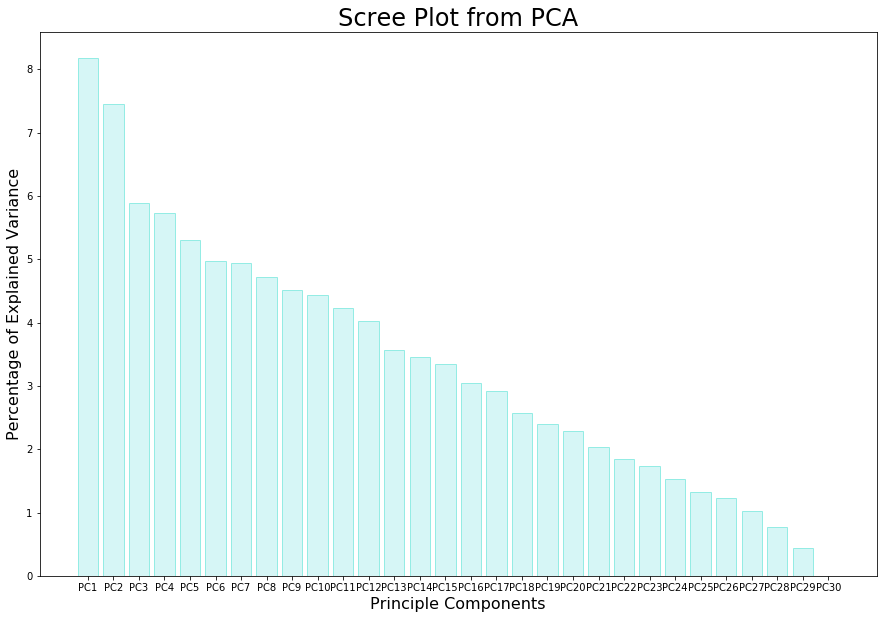

In [10]:
#Make Scree Plot of transposed data - norm data
#Initialize figure
fig = plt.figure(figsize=(15,10))

#Plot histogram
plt.bar(x = range(1, len(var_exp_t) + 1), height = var_exp_t, tick_label = col_labels_t, color = 'paleturquoise', edgecolor = 'turquoise', alpha=0.5)

#Titles and lables
plt.ylabel('Percentage of Explained Variance', fontsize=16)
plt.xlabel('Principle Components', fontsize=16)
plt.title("Scree Plot from PCA", fontsize=24)

plt.show()

In [77]:
#Calculate Loading Scores of PCs
ls_t = pd.DataFrame(np.abs(pca_t.components_[0]), index = samples, columns = ['Loading Score'])

#Sort the loading scores based on their magnitude
sorted_t = ls_t.abs().sort_values(by = ['Loading Score'], ascending = False)
top = sorted_t[0:29]
sorted_t

,Loading Score
OTU_46,0.226010
OTU_145,0.208004
OTU_29,0.194245
OTU_76,0.183998
OTU_49,0.179547
OTU_94,0.173489
OTU_61,0.173213
OTU_70,0.168763
OTU_54,0.164549
OTU_64,0.164439


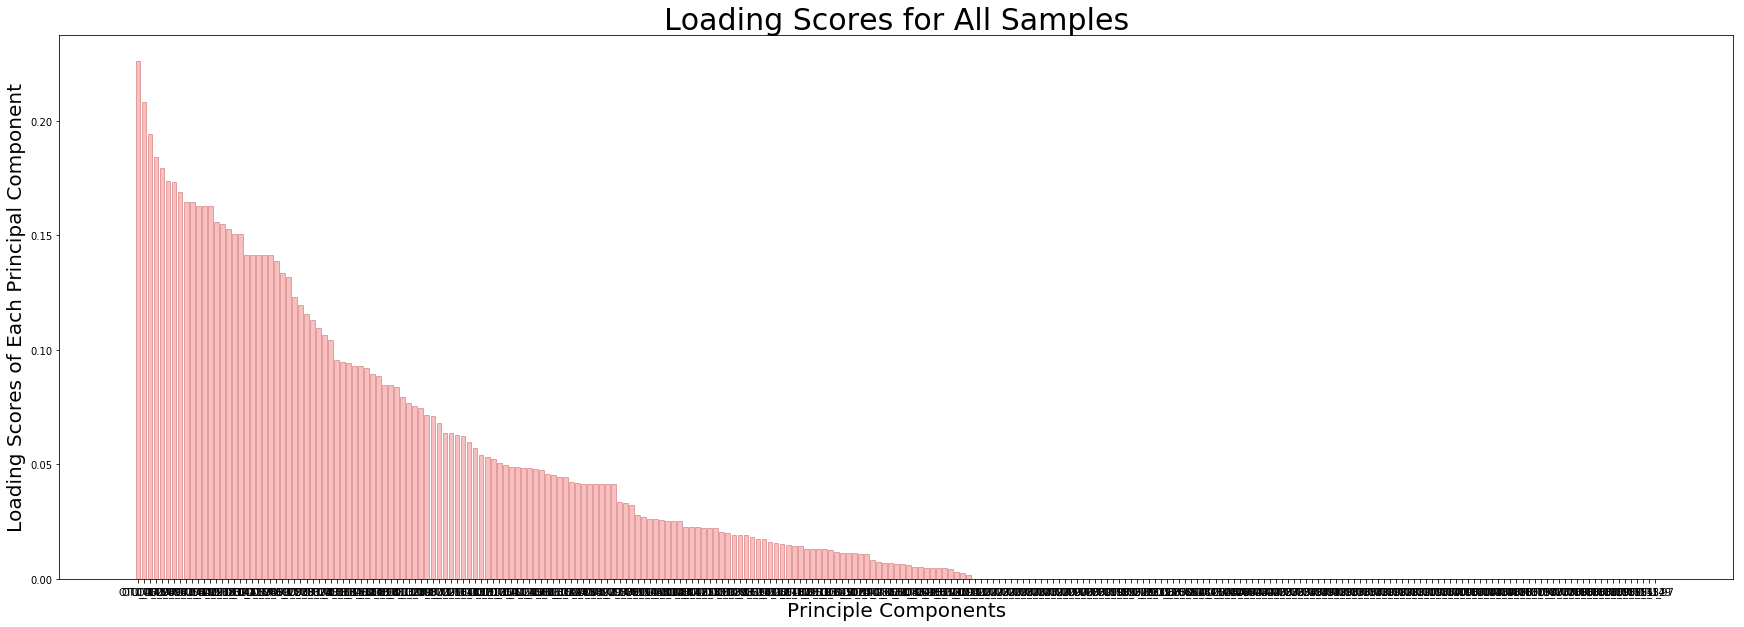

In [12]:
#Rough plot of all loading scores
#Initialize figure
fig2 = plt.figure(figsize=(30,10))

#Plot histogram
plt.bar(list(sorted_t.index), sorted_t['Loading Score'], edgecolor = 'indianred', color = 'lightcoral', alpha=0.5)

#Titles and lables
plt.ylabel('Loading Scores of Each Principal Component', fontsize=20)
plt.xlabel('Principle Components', fontsize=20)
plt.title('Loading Scores for All Samples', fontsize=30)

plt.show()

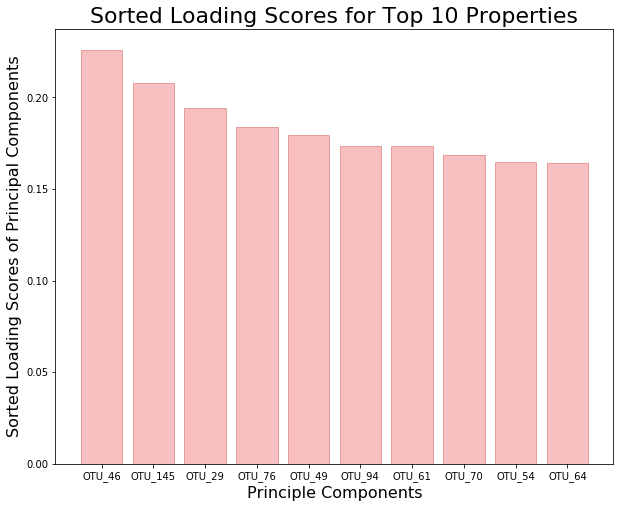

In [13]:
#Rough plot of top ten PCs
#Initialize figure
fig2 = plt.figure(figsize=(10,8))

#Plot histogram
plt.bar(list(sorted_t.index)[0:10],sorted_t['Loading Score'].iloc[0:10], edgecolor = 'indianred', color = 'lightcoral', alpha=0.5)

#Titles and lables
plt.ylabel('Sorted Loading Scores of Principal Components', fontsize=16)
plt.xlabel('Principle Components', fontsize=16)
plt.title('Sorted Loading Scores for Top 10 Properties', fontsize=22)

plt.show()

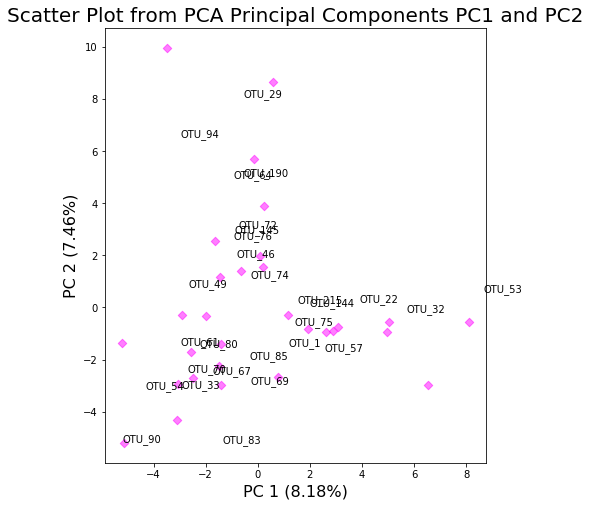

In [81]:
#Scatter Plot of transposed data
#Initialize figure
fig2 = plt.figure(figsize=(10,8))

#dictionary of colors
# colors = {'PC1': 'cyan', 'PC2': 'magenta'}
# cvec = [colors[col] for col in col_labels_t[0:1]]

#Plot histogram
plt.scatter(pca_df_t['PC2'], pca_df_t['PC1'], alpha=0.5, marker='D', color='magenta')

#Titles and lables
plt.ylabel('PC 2 (%.2f%%)' % (pca_t.explained_variance_ratio_[1]*100), fontsize=16)
plt.xlabel('PC 1 (%.2f%%)' % (pca_t.explained_variance_ratio_[0]*100), fontsize=16)
plt.title("Scatter Plot from PCA Principal Components PC1 and PC2", fontsize=20)
plt.axis('scaled')
for i, txt in enumerate(top.index):
    plt.annotate(txt, (pca_df_t.iloc[:,0][i], pca_df_t.iloc[:,1][i]))
    
plt.show()

## Part III - Generate a Partial Correlation Matrix 

#### A partial correlation is used to measure the degree of association between two random variables, with the effects of a set of controlling random variables removed. This matrix allows us to understand the degree of association between all the species with each other. 

#### This involves 3 steps - 
#### 1) Pairwise covariance - computes the variance between each of the individual species with all the others (how two species vary together)
#### 2) Ledoit Wolf shrinkage - estimate values form the imperial matrix while making it diagonalizable by pulling extreme coefficients to centralized values
#### 3) Inverse - taking the inverse of the pairwise correlation matrix gives the partial correlation


    - Compute a pairwise covariance of all the samples (columns)
    - Perform a Ledoit Wolf shrinkage, and store the precision
    - Take the inverse of the LW shrinkage matrix to get the partial correlation


In [15]:
#Compute pairwise covariance of columns (samples)
covar_t = norm_t.cov()
covar_t.head()

,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
OTU_1,1.034483,-0.031057,-0.341624,0.442157,-0.322607,0.201692,-0.009276,-0.015398,-0.071400,-0.169670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_2,-0.031057,1.034483,0.174098,-0.499725,0.182373,-0.313167,0.127484,-0.184946,-0.172539,0.309858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_3,-0.341624,0.174098,1.034483,-0.281062,0.079140,-0.113729,0.046475,-0.154361,-0.116858,-0.094836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_5,0.442157,-0.499725,-0.281062,1.034483,-0.212635,0.374124,-0.179103,0.100782,0.128553,-0.103833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_4,-0.322607,0.182373,0.079140,-0.212635,1.034483,-0.131860,0.137457,-0.096871,-0.070073,-0.041263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#Save list of column names
col_names = list(covar_t)
#col_names

In [17]:
#Initialize ledoit-wolf object
lw = LedoitWolf()

In [18]:
#LW Shrinkage of Covariance Matrix
#Does it use the covariance matrix or regular input matrix?
lwdf_t = pd.DataFrame(lw.fit(covar_t).get_precision())
lwdf_t

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,500.657365,-11.417813,23.924307,-39.390770,14.109460,5.496017,1.247440,9.196729,14.112731,26.365318,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-11.417813,529.198919,9.470986,37.059128,7.948972,21.488997,-8.547827,15.388938,16.229420,-38.543177,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,23.924307,9.470986,519.824894,11.360563,13.663024,-10.430967,-0.404190,5.091181,2.339739,12.143834,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,-39.390770,37.059128,11.360563,541.541281,6.029121,-13.096725,19.124581,0.354618,-4.125933,6.514382,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,14.109460,7.948972,13.663024,6.029121,473.301510,-2.125712,-7.145477,-0.808287,-1.353690,34.079127,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,5.496017,21.488997,-10.430967,-13.096725,-2.125712,436.329544,12.589444,2.846004,-0.084169,7.194437,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,1.247440,-8.547827,-0.404190,19.124581,-7.145477,12.589444,533.606955,-63.120627,-60.555934,-3.751946,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,9.196729,15.388938,5.091181,0.354618,-0.808287,2.846004,-63.120627,534.778930,-96.464458,9.781242,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,14.112731,16.229420,2.339739,-4.125933,-1.353690,-0.084169,-60.555934,-96.464458,532.409448,7.913062,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,26.365318,-38.543177,12.143834,6.514382,34.079127,7.194437,-3.751946,9.781242,7.913062,438.248324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [19]:
#Take the inverse of the lw matrix
#This is the partial correlation matrix
parcor_t = pd.DataFrame(np.linalg.inv(lwdf_t), index = col_names, columns = col_names)
parcor_t

,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
OTU_1,0.027323,-0.004459,-0.012153,0.015746,-0.010428,0.009596,0.000659,0.003736,0.002260,-0.002704,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_2,-0.004459,0.031492,0.011357,-0.016753,0.011050,-0.010598,0.004836,-0.006196,-0.005423,0.007356,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_3,-0.012153,0.011357,0.026432,-0.012093,0.008094,-0.007099,0.002124,-0.006686,-0.005495,-0.000346,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_5,0.015746,-0.016753,-0.012093,0.032403,-0.009012,0.014009,-0.003837,0.006718,0.006880,-0.003109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_4,-0.010428,0.011050,0.008094,-0.009012,0.022048,-0.006094,0.005211,-0.004015,-0.003011,0.002972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_239,0.009596,-0.010598,-0.007099,0.014009,-0.006094,0.018498,-0.006266,-0.000735,-0.000520,-0.001989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_10,0.000659,0.004836,0.002124,-0.003837,0.005211,-0.006266,0.027959,0.016530,0.015787,0.002359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_8,0.003736,-0.006196,-0.006686,0.006718,-0.004015,-0.000735,0.016530,0.027620,0.025199,-0.000516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_7,0.002260,-0.005423,-0.005495,0.006880,-0.003011,-0.000520,0.015787,0.025199,0.027044,-0.000161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_6,-0.002704,0.007356,-0.000346,-0.003109,0.002972,-0.001989,0.002359,-0.000516,-0.000161,0.014511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Part IV - Hypothesis Testing

#### First start by visualizing the data with a histogram of all the datapoints
 - Too many samples (253) to show the legend
 - The majority of samples have values between -0.95 and 0.1
     - These must be eliminated for the graphical network as they do not provide much cooccurence information

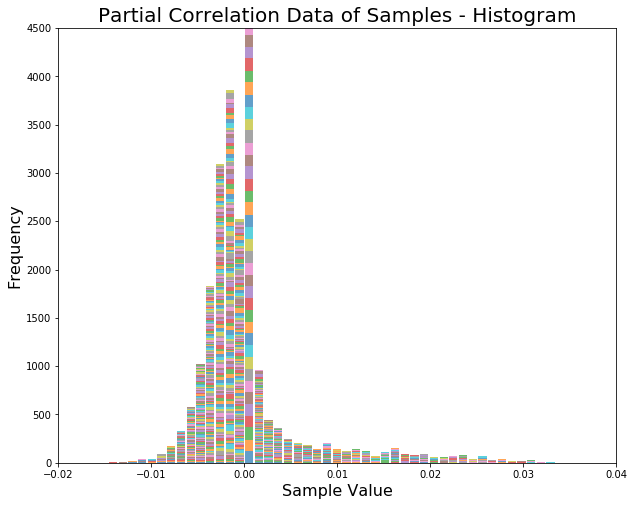

In [20]:
# Initialize plot
fig = plt.figure(figsize=(10,8))

# Histogram
bins = plt.hist(x=parcor_t, bins=50, stacked = True, alpha=0.7, rwidth=0.85)

# Plot lables
plt.xlabel('Sample Value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Partial Correlation Data of Samples - Histogram', fontsize=20)
#plt.legend(loc = 'right')
plt.xlim(-0.02, 0.04)
plt.ylim(0, 4500)


plt.show()

## Modify the partial correlation matrix to make a clearly visualizable graphical network

#### Steps involved:
    - Stack all the columns to generate a single colunm with all 'Weight' values (with the row and columns indecies as the
    first two columns)
    - As the partial correlation matrix is symmetrical, half the stacked values are repeats
        - Remove repeats by using a droping duplicates function
    - Sort the columns (according to 'Weight') in ascending order, to determine the top and botton 2.5% of data (the most
    telling portion of the data) to be used in the final network
    - Store top and botton 2.5% of data in a new dataframe (consisting of 1,600 rows from the original 32,000)

In [21]:
# concatenate all the columns by stacking
concat = parcor_t.stack(dropna = False)
df_concat = concat.reset_index()
df_concat.columns = ['A', 'B', 'Weights']
df_concat

,A,B,Weights
0,OTU_1,OTU_1,0.027323
1,OTU_1,OTU_2,-0.004459
2,OTU_1,OTU_3,-0.012153
3,OTU_1,OTU_5,0.015746
4,OTU_1,OTU_4,-0.010428
5,OTU_1,OTU_239,0.009596
6,OTU_1,OTU_10,0.000659
7,OTU_1,OTU_8,0.003736
8,OTU_1,OTU_7,0.002260
9,OTU_1,OTU_6,-0.002704


In [22]:
# drop duplicate rows
drop_dupes = df_concat[~df_concat[['A', 'B']].apply(frozenset, axis=1).duplicated()]
#print(drop_dupes)

In [23]:
# sort the columns in ascending order, by the weights column
df_sort = drop_dupes.sort_values(by = 'Weights')
df_sort

,A,B,Weights
256,OTU_2,OTU_5,-0.016753
268,OTU_2,OTU_24,-0.014554
784,OTU_5,OTU_16,-0.014493
25,OTU_1,OTU_16,-0.013934
83,OTU_1,OTU_145,-0.013648
3820,OTU_24,OTU_16,-0.013230
8910,OTU_81,OTU_51,-0.012804
86,OTU_1,OTU_46,-0.012249
2,OTU_1,OTU_3,-0.012153
509,OTU_3,OTU_5,-0.012093


In [24]:
# store top and bottom 2.5% of values in two lists
# also ascending order
df_len = len(df_sort)
percent = int(df_len * (0.025))
top_percent = df_sort[0:percent]
bottom_percent = df_sort[-percent:]
total_5 = top_percent.append(bottom_percent).dropna()
total_5

,A,B,Weights
256,OTU_2,OTU_5,-0.016753
268,OTU_2,OTU_24,-0.014554
784,OTU_5,OTU_16,-0.014493
25,OTU_1,OTU_16,-0.013934
83,OTU_1,OTU_145,-0.013648
3820,OTU_24,OTU_16,-0.013230
8910,OTU_81,OTU_51,-0.012804
86,OTU_1,OTU_46,-0.012249
2,OTU_1,OTU_3,-0.012153
509,OTU_3,OTU_5,-0.012093


## Histogram Plot of Final Data for the Graphical Network 
#### This is based on the datafram that constitutes of the most telling 5% of the data, from the extremities

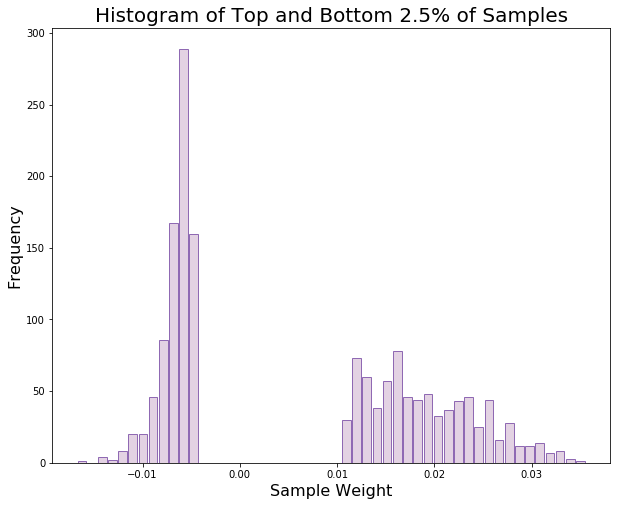

In [25]:
# Initialize plot
fig = plt.figure(figsize=(10,8))

# Histogram
bins = plt.hist(x=total_5['Weights'], bins=50, stacked = True, alpha=0.7, rwidth=0.85, color="thistle", edgecolor="rebeccapurple")

# Plot lables
plt.xlabel('Sample Weight', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Top and Bottom 2.5% of Samples', fontsize=20)
#plt.legend(loc = 'right')
#plt.xlim(-0.02, 0.04)
#plt.ylim(0, 4500)


plt.show()

## Test pertinent values and create Graphical Networks
 - Make a cell that can test the target values and the number of connections a specified target is linked to
 - The first graphical network is a plain network that shows the targets, sources, popular sources and the sign (positive or negative) of the edges
 - The second graphical network is an interactive network generated using hvplot that highlights all connected edges in bright green when hovering over a source, and showes the source and edges in blue when selected

In [94]:
# # Check data
# # store source and target lists
# source = list(total_5.A.unique())
# target = list(total_5.B.unique())

# # check 
# # number of connections specified value is linked to (has coming out of it)
# #[g.degree(target) for target in target]
# g.degree()

#function to manually see weights between two specified species
def get_weight(otu1, otu2):
    return total_5.loc[np.logical_and(total_5['A'] == otu1, total_5['B'] == otu2)]

In [106]:
get_weight('OTU_1', 'OTU_5')

,A,B,Weights
3,OTU_1,OTU_5,0.015746


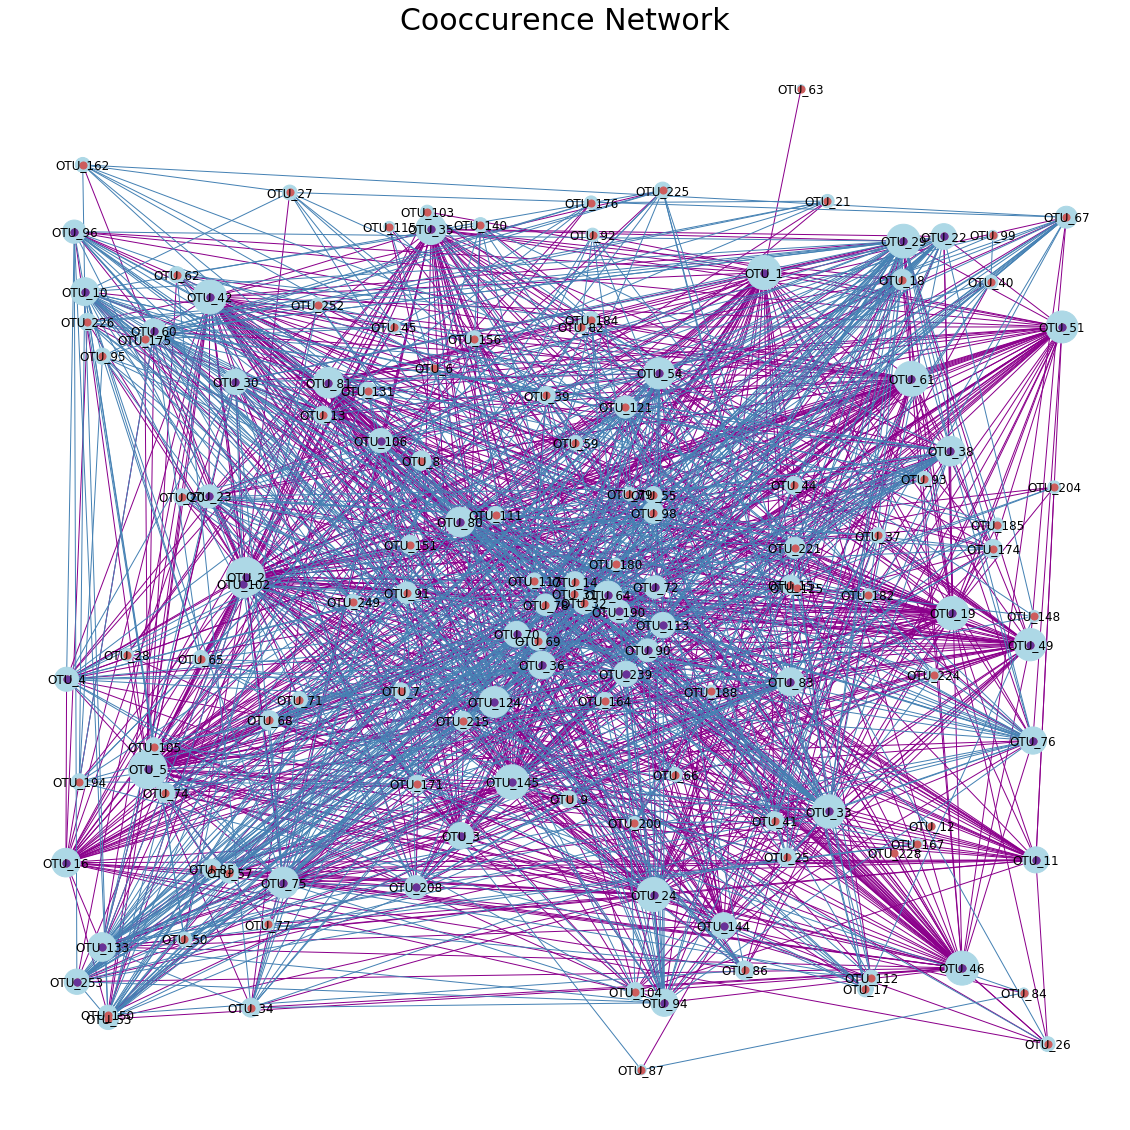

In [27]:
# Create the graph and plot
plt.figure(figsize=(20, 20))
g = nx.from_pandas_edgelist(total_5, source='A', target='B', edge_attr=['Weights'])
nodes = g.nodes()
edges = g.edges()

# Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=1, scale=1)

# Unique lists of A and B columns
source = list(total_5.A.unique())
target = list(total_5.B.unique())

# Draw the parts
# Edges
edge_colors = []
for i in list(total_5['Weights']):
#    edge_colors = ['steelblue' if i > 0 else 'darkmagenta' for e in edges]
    if i > 0:
        edge_colors.append('steelblue')
    else:
        edge_colors.append('darkmagenta')

nx.draw_networkx_edges(g, layout, edge_color=edge_colors)

# Target details
# manipulate size based on abundance
target = [node for node in nodes if node in target]
size = [g.degree(node) * 20 for node in nodes if node in target]
nx.draw_networkx_nodes(g, layout, nodelist=target, node_size=size, node_color='lightblue')

# Source details
source = [node for node in nodes if node in source]
nx.draw_networkx_nodes(g, layout, nodelist=source, node_size=50, node_color='indianred')

# Popular source details
pop_source = [node for node in nodes if node in source and g.degree(node) > 25]
nx.draw_networkx_nodes(g, layout, nodelist=pop_source, node_size=50, node_color='rebeccapurple')

# All target labels
target_dict = dict(zip(target, target))
nx.draw_networkx_labels(g, layout, labels=target_dict, font_size=12, color='black')

# Turn off axis
plt.axis('off')

plt.title("Cooccurence Network", fontsize=30)

# Show graph
plt.show()

In [28]:
plt.figure(figsize=(20, 20))
g = nx.from_pandas_edgelist(total_5, source='A', target='B', edge_attr=['Weights'])
nodes = g.nodes()
edges = g.edges()

# Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=1, scale=1)

# Unique lists of A and B columns
source = list(total_5.A.unique())
target = list(total_5.B.unique())

# Draw the parts
# Edges
edge_colors = []
for i in list(total_5['Weights']):
    if i > 0:
        edge_colors.append('steelblue')
    else:
        edge_colors.append('darkmagenta')

edges = hvnx.draw_networkx_edges(g, layout, edge_color=edge_colors, edge_width=1.25,width=1000, height=1000).opts(tools=[HoverTool(tooltips=[('Sample_name', '@index_hover')])])

# Target details
# manipulate size based on abundance
target = [node for node in nodes if node in target]
target_dict = dict(zip(target, target))
size = [g.degree(node) * 20 for node in nodes if node in target]
targets = hvnx.draw_networkx_nodes(g, layout, labels=target_dict, nodelist=target, node_size=size, node_color='lightblue')

# Source details
source = [node for node in nodes if node in source]
sources = hvnx.draw_networkx_nodes(g, layout, nodelist=source, node_size=50, node_color='indianred')

# Popular source details
pop_source = [node for node in nodes if node in source and g.degree(node) > 25]
pops = hvnx.draw_networkx_nodes(g, layout, nodelist=pop_source, node_size=50, node_color='purple')

# show plot
edges * targets * sources * pops 

:Overlay
   .Graph.I   :Graph   [start,end]   (Weights,edge_line_color)
   .Graph.II  :Graph   [start,end]   (Weights)
   .Labels.I  :Labels   [x,y]   (text)
   .Graph.III :Graph   [start,end]   (Weights)
   .Graph.IV  :Graph   [start,end]   (Weights)

<Figure size 1440x1440 with 0 Axes>

In [32]:
# import ipywidgets as widgets
# from ipywidgets import interact

# def graphing_fxn(otu=None, abundance_scale=20, node_size=50, popular_size=25, layout='spring'):
#     if len(otu) == 0:
#         print('empty otu')
#     else:
#         print(otu)
#     print(g.degree(otu))
#     print(abundance_scale)
#     print(node_size)
#     print(popular_size)
#     print(layout)

# interact(graphing_fxn, otu='', abundance_scale=(1,40), node_size=(1,100), 
#          popular_size=(10,50),layout={
#         'spring' : 'spring',
#         'planar' : 'planar',
#         'circular' : 'circular',
#         'random' : 'random',
#         'shell' : 'shell'})   

In [33]:
# def interactive_model(data, layout_type, abundance, popular_size, node_size):
#     # Create the graph and plot
#     plt.figure(figsize=(20, 20))
#     g = nx.from_pandas_edgelist(data, source='A', target='B', edge_attr=['Weights'])
#     nodes = g.nodes()
#     edges = g.edges()

#     # Create a layout for our nodes 
#     #layout = nx.layouttype_layout(g,iterations=1, scale=1)

#     if layout_type is 'circular':
#         layout = nx.circular_layout(g)
#     elif layout_type is 'planar':
#         layout = nx.planar_layout(g)
#     elif layout_type is 'random':
#         layout = nx.random_layout(g)
#     elif layout_type is 'shell':
#         layout = nx.shell_layout(g)
#     else:
#         layout = nx.spring_layout(g)

#     # Unique lists of A and B columns
#     source = list(data.A.unique())
#     target = list(data.B.unique())

#     # Draw the parts
#     # Edges
#     edge_colors = []
#     for i in list(total_5['Weights']):
#         if i > 0:
#             edge_colors.append('steelblue')
#         else:
#             edge_colors.append('darkmagenta')

#     edges = hvnx.draw_networkx_edges(g, layout, edge_color=edge_colors, edge_width=1.25, width=800, height=800).opts(tools=[HoverTool(tooltips=[('Sample_name', '@index_hover')])])

#     # Target details
#     # manipulate size based on abundance
#     target = [node for node in nodes if node in target]
#     target_dict = dict(zip(target, target))
#     size = [g.degree(node) * abundance for node in nodes if node in target]
#     targets = hvnx.draw_networkx_nodes(g, layout, labels=target_dict, nodelist=target, node_size=size, node_color='lightblue')

#     # Source details
#     source = [node for node in nodes if node in source]
#     sources = hvnx.draw_networkx_nodes(g, layout, nodelist=source, node_size=node_size, node_color='indianred')

#     # Popular source details
#     pop_source = [node for node in nodes if node in source and g.degree(node) > popular_size]
#     pops = hvnx.draw_networkx_nodes(g, layout, nodelist=pop_source, node_size=node_size, node_color='purple')

#     # show plot
#     return edges * targets * sources * pops 
    

In [34]:
# model = interactive_model(total_5, 'spring', 20, 25, 50)